Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Epoch 1:    train/loss: 1.2269   valid/loss: 0.8085   train/acc: 0.5000   valid/acc: 0.5000
Epoch 12:   train/loss: 1.4948   valid/loss: 1.6893   train/acc: 0.5429   valid/acc: 0.4333
Epoch 24:   train/loss: 1.0432   valid/loss: 0.8909   train/acc: 0.6143   valid/acc: 0.6167
Epoch 36:   train/loss: 0.7846   valid/loss: 0.9220   train/acc: 0.5857   valid/acc: 0.4667
Epoch 48:   train/loss: 0.6431   valid/loss: 0.7258   train/acc: 0.6000   valid/acc: 0.4333
Epoch 60:   train/loss: 0.5780   valid/loss: 0.6371   train/acc: 0.6714   valid/acc: 0.6000
Epoch 72:   train/loss: 0.5030   valid/loss: 0.5262   train/acc: 0.7429   valid/acc: 0.6667
Epoch 84:   train/loss: 0.5036   valid/loss: 0.5879   train/acc: 0.7143   valid/acc: 0.5833
Epoch 96:   train/loss: 0.4488

Test accuracy: 0.8


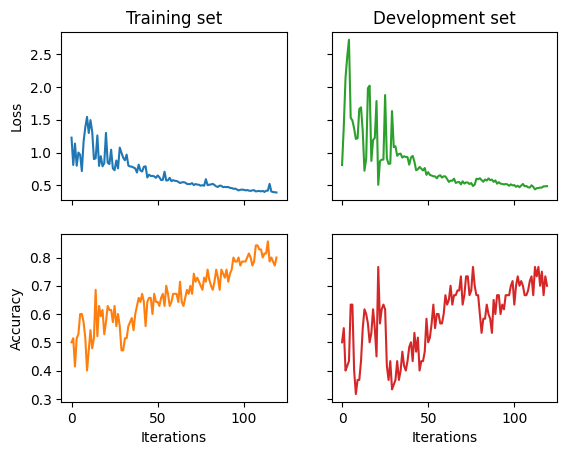

In [1]:
import warnings

warnings.filterwarnings( 'ignore' )

import os

os.environ[ 'TOKENIZERS_PARALLELISM' ] = 'false'

# # # Lectura de las frases # # #

def read_data ( filename ) :
    labels , sentences = [] , []
    with open( filename ) as f :
        for line in f :
            t = int( line[ 0 ] )
            labels.append( [ t , 1 - t ] )
            sentences.append( line[ 1 : ].strip() )
    return labels , sentences

train_labels , train_sentences = read_data( './Datasets/train_data.txt' )

dev_labels , dev_sentences = read_data( './Datasets/dev_data.txt' )

test_labels , test_sentences = read_data( './Datasets/test_data.txt' )

# # # Creación de los diagramas # # #

from lambeq import BobcatParser

parser = BobcatParser( verbose = 'text' )

raw_train_diagrams = parser.sentences2diagrams( train_sentences )

raw_dev_diagrams = parser.sentences2diagrams( dev_sentences )

raw_test_diagrams = parser.sentences2diagrams( test_sentences )

from lambeq import remove_cups

train_diagrams = [ remove_cups( diagram ) for diagram in raw_train_diagrams ]

dev_diagrams = [ remove_cups( diagram ) for diagram in raw_dev_diagrams ]

test_diagrams = [ remove_cups( diagram ) for diagram in raw_test_diagrams ]

# # # Creación de los circuitos cuánticos # # #

from lambeq import AtomicType

N = AtomicType.NOUN

S = AtomicType.SENTENCE

from lambeq import IQPAnsatz

ansatz = IQPAnsatz( { N : 1 , S : 1 } , n_layers = 1 , n_single_qubit_params = 3 )

train_circuits = [ ansatz( diagram ) for diagram in train_diagrams ]

dev_circuits = [ ansatz( diagram ) for diagram in dev_diagrams ]

test_circuits = [ ansatz( diagram ) for diagram in test_diagrams ]

# # # Creación del modelo # # #

all_circuits = train_circuits + dev_circuits + test_circuits

from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

backend_config = {
    'backend' : backend ,
    'compilation' : backend.default_compilation_pass( 2 ) ,
    'shots' : 8192
}

from lambeq import TketModel

model = TketModel.from_diagrams( all_circuits , backend_config = backend_config )

# # # Entrenamiento del modelo # # #

import numpy as np

loss = lambda y_hat , y : - np.sum( y * np.log( y_hat ) ) / len( y )

acc = lambda y_hat , y : np.sum( np.round( y_hat ) == y ) / len( y ) / 2

from lambeq import SPSAOptimizer

EPOCHS = 120

from lambeq import QuantumTrainer

trainer = QuantumTrainer(
    model ,
    loss_function = loss ,
    epochs = EPOCHS ,
    optimizer = SPSAOptimizer ,
    optim_hyperparams = { 'a' : 0.05 , 'c' : 0.06 , 'A' : 0.01 * EPOCHS } ,
    evaluate_functions = { 'acc' : acc } ,
    evaluate_on_train = True ,
    verbose = 'text' ,
    log_dir = './' ,
    seed = 2
)

from lambeq import Dataset

train_dataset = Dataset( train_circuits , train_labels , batch_size = 30 )

dev_dataset = Dataset( dev_circuits , dev_labels , shuffle = False )

trainer.fit( train_dataset , dev_dataset , logging_step = 12 )

# # # Obtención de los resultados # # #

import matplotlib.pyplot as plt

fig , ( ( ax_tl , ax_tr ) , ( ax_bl , ax_br ) ) = plt.subplots( 2 , 2 , sharex = True , sharey = 'row' )
ax_tl.set_title( 'Training set' )
ax_tr.set_title( 'Development set' )
ax_bl.set_xlabel( 'Iterations' )
ax_br.set_xlabel( 'Iterations' )
ax_bl.set_ylabel( 'Accuracy' )
ax_tl.set_ylabel( 'Loss' )

colours = iter( plt.rcParams[ 'axes.prop_cycle' ].by_key()[ 'color' ] )
ax_tl.plot( trainer.train_epoch_costs , color = next( colours ) )
ax_bl.plot( trainer.train_results[ 'acc' ] , color = next( colours ) )
ax_tr.plot( trainer.val_costs , color = next( colours ) )
ax_br.plot( trainer.val_results[ 'acc' ] , color = next( colours ) )

test_acc = acc( model( test_circuits ) , test_labels )

print( 'Test accuracy:' , test_acc )

In [2]:
sentence = 'skillful person prepares useful software .'

raw_diagram = parser.sentence2diagram( sentence )

raw_circuit = ansatz( raw_diagram )

diagram = remove_cups( raw_diagram )

circuit = ansatz( diagram )

In [3]:
from pytket.circuit.display import render_circuit_jupyter

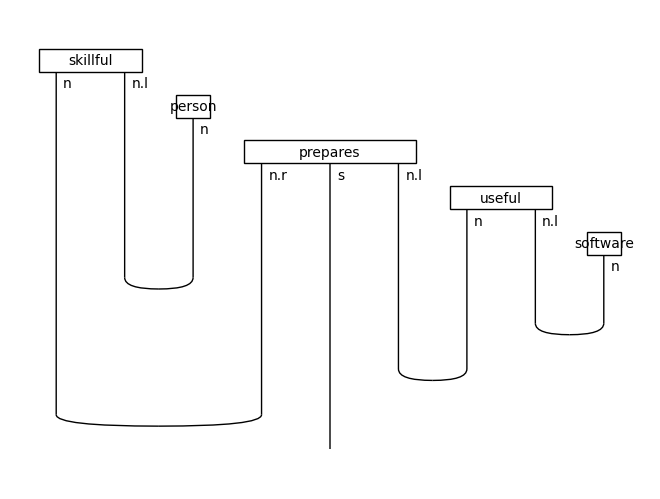

In [4]:
raw_diagram.draw()

In [5]:
render_circuit_jupyter( raw_circuit.to_tk() )

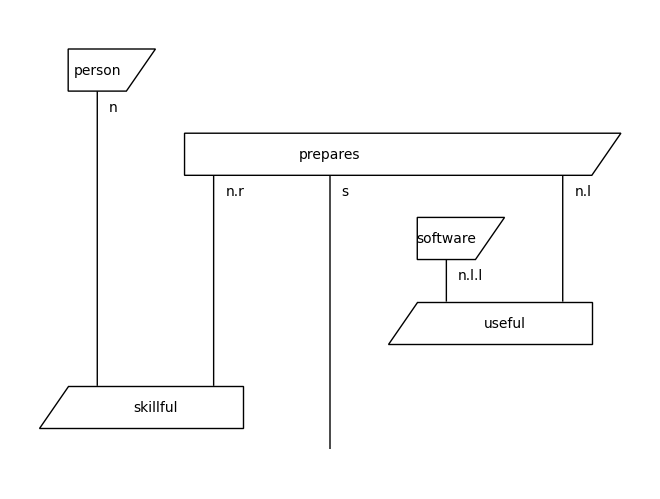

In [6]:
diagram.draw()

In [7]:
render_circuit_jupyter( circuit.to_tk() )